In [1]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.optimize import curve_fit
import cv2
from math import *
from scipy.ndimage import rotate
import math
from scipy.stats import linregress, norm
import matplotlib.gridspec as gridspec

<h1>DEFINE<h1>

In [2]:
def eclipse_fit_full(array_of_gray_pic):

    thresh = cv2.threshold(array_of_gray_pic.astype(np.uint8),8 , 255, cv2.THRESH_BINARY)[1]

    # find largest contour
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]

    big_contour = max(contours, key=cv2.contourArea)

    # fit contour to ellipse and get ellipse center, minor and major diameters and angle in degree 
    ellipse = cv2.fitEllipse(big_contour)
    (xc,yc),(d1,d2),angle = ellipse


    # draw ellipse
    result = array_of_gray_pic.copy()
    cv2.ellipse(result, ellipse, (255, 255, 255), 2)

    # draw vertical line
    # compute major radius
    rmajor = max(d1,d2)/2
    if angle > 90:
        angle = angle - 90
    else:
        angle = angle + 90
    xtop = xc + math.cos(math.radians(angle))*rmajor
    ytop = yc + math.sin(math.radians(angle))*rmajor
    xbot = xc + math.cos(math.radians(angle+180))*rmajor
    ybot = yc + math.sin(math.radians(angle+180))*rmajor
    Elipse_pic = np.array(cv2.line(result, (int(xtop),int(ytop)), (int(xbot),int(ybot)), (255, 255, 255), 2))

    return Elipse_pic,angle,thresh

In [3]:
def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))
def gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt

In [4]:
def gauss_fit_pcov(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return pcov

<h1>Example of signal analyze<h1>

In [5]:
single_subtract = []
MOT_pic_subtract = []
n_of_point = 0
im = io.imread('Mot_18-08\\1ms.tif').astype(np.int8)
pic_per_time_point = int(im.shape[0] / 2)
single_subtract = []
with_mot_l = []
with_o_mot_l = []
for i in range(pic_per_time_point):
    with_out_mot = im[(2 * i) + 1]
    with_o_mot_l.append(with_out_mot)
    
    with_mot = im[(2 * i)]
    with_mot_l.append(with_mot)
    
    subtract_array = np.zeros(with_out_mot.shape)
    subtract_array[with_out_mot != 0] = 1 - (with_mot[with_out_mot != 0] / with_out_mot[with_out_mot != 0])
    subtract_array[subtract_array < 0] = 0
    single_subtract.append(subtract_array)
    n_of_point += 1

In [6]:
sum_wo_a = np.zeros([1080,1440])
sum_w_a = np.zeros([1080,1440])
sum_sub = np.zeros([1080,1440])
for i in range(15):
    sum_wo_a += with_o_mot_l[i]
    sum_w_a += with_mot_l[i]
    sum_sub += single_subtract[i]
sum_wo_a = np.array(sum_wo_a)/15
sum_w_a = np.array(sum_w_a)/15
sum_sub =np.array(sum_sub)/15

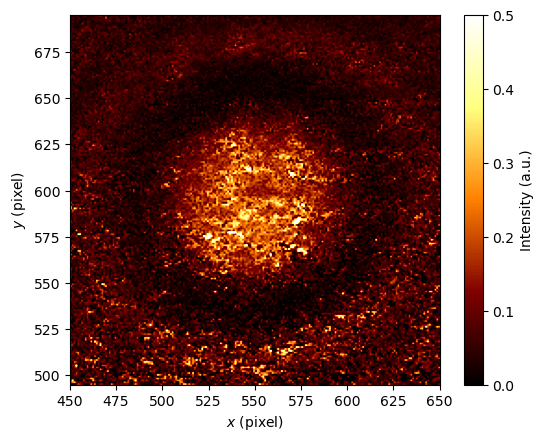

In [62]:
colormap_fig2 = 'afmhot'
plt.imshow(sum_sub[495:695,450:650],vmin=0,vmax=0.5,extent =(450,650,495,695),cmap = colormap_fig2)

# plt.title('Extracted image')
plt.xlabel('$x$ (pixel)')
plt.ylabel('$y$ (pixel)')
plt.colorbar(label = 'Intensity (a.u.)')
plt.savefig('D:\\PICTURE\\Picture\\Pyplot\\2nd\\croped motttttttt.png')

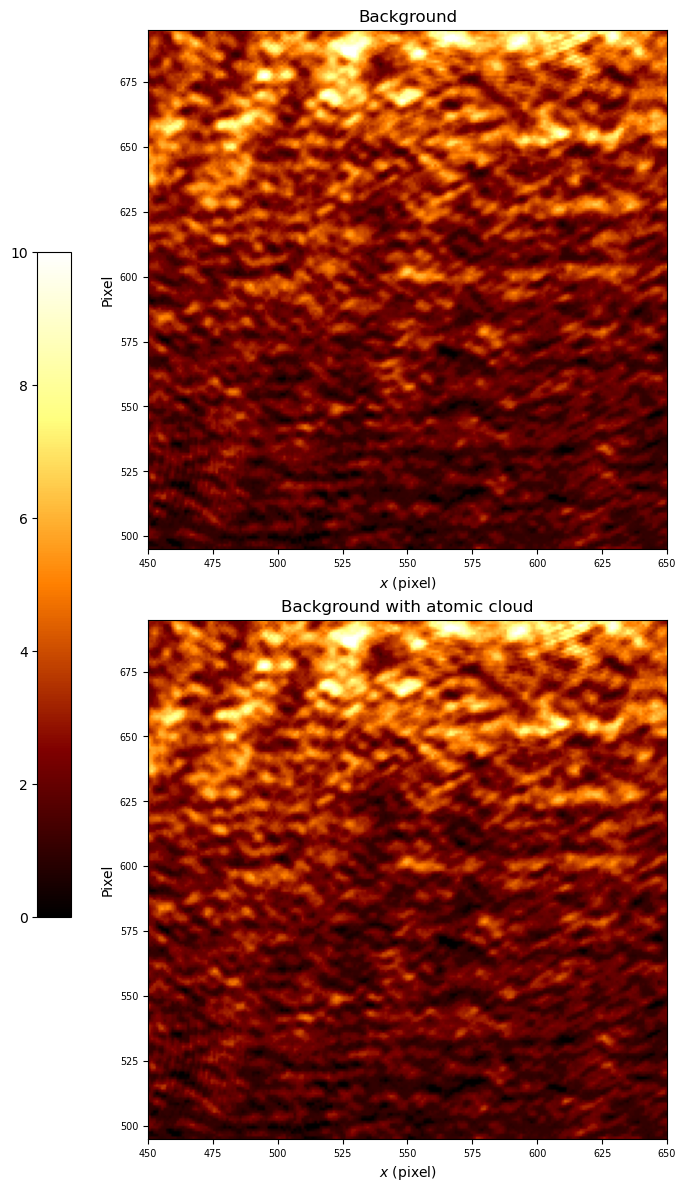

In [63]:
colormap_fig1 = 'afmhot'
fig = plt.figure(figsize=(8, 12))
axs = np.zeros(2, dtype=object)
gs = fig.add_gridspec(2,1)
axs[0] = fig.add_subplot(gs[0,0])
axs[1] = fig.add_subplot(gs[1,0])


axs1 = axs[0].imshow(sum_wo_a[495:695,450:650],vmin=0,vmax=10,extent =(450,650,495,695),cmap = colormap_fig1)
axs[0].set_title('Background')
axs[0].set_xlabel('$x$ (pixel)')
axs[0].set_ylabel('Pixel')



axs2 = axs[1].imshow(sum_w_a[495:695,450:650],vmin=0,vmax=10,extent =(450,650,495,695),cmap = colormap_fig1)
axs[1].set_title('Background with atomic cloud')
axs[1].set_xlabel('$x$ (pixel)')
axs[1].set_ylabel('Pixel')



for x in axs.flat:
    for tick in x.xaxis.get_major_ticks():
        tick.label.set_fontsize('x-small')
    for tick in x.yaxis.get_major_ticks():
        tick.label.set_fontsize('x-small')
# fig.suptitle('Shadow absorption imaing')

fig.tight_layout(pad = 1, h_pad = 0.5)
fig.colorbar(axs1, ax=axs[:2], shrink=0.6, location='left')
# plt.savefig('D:\\PICTURE\\Picture\\Pyplot\\2nd\\croped mot compare.png')

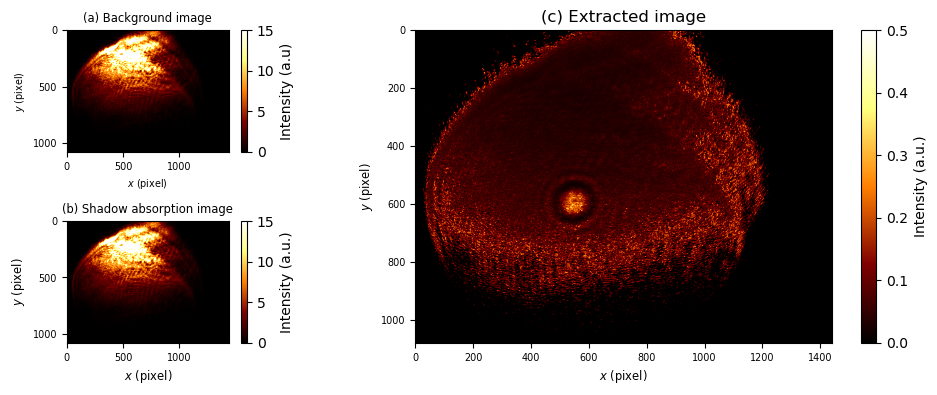

In [68]:
colormap_fig2 = 'afmhot'
fig = plt.figure(figsize=(10, 4))
axs = np.zeros(3, dtype=object)
gs = fig.add_gridspec(2, 3)
axs[0] = fig.add_subplot(gs[0, 0])
axs[1] = fig.add_subplot(gs[1, 0])
axs[2] = fig.add_subplot(gs[0:2,1:3])


axs1 = axs[0].imshow(sum_wo_a,vmin=0,vmax=15,cmap = colormap_fig2)
axs[0].set_title('(a) Background image',fontsize = 'small')
axs[0].set_xlabel('$x$ (pixel)',fontsize = 'x-small')
axs[0].set_ylabel('$y$ (pixel)',fontsize = 'x-small')
fig.colorbar(axs1, ax=axs[0], label = 'Intensity (a.u)')

axs2 = axs[1].imshow(sum_w_a,vmin=0,vmax=15,cmap = colormap_fig2)
axs[1].set_title('(b) Shadow absorption image',fontsize = 'small')
axs[1].set_xlabel('$x$ (pixel)',fontsize = 'small')
axs[1].set_ylabel('$y$ (pixel)',fontsize = 'small')
fig.colorbar(axs2, ax=axs[1], label = 'Intensity (a.u.)')
axs3 = axs[2].imshow(sum_sub,vmin=0,vmax=0.5,cmap = colormap_fig2)
axs[2].set_title('(c) Extracted image')
axs[2].set_xlabel('$x$ (pixel)',fontsize = 'small')
axs[2].set_ylabel('$y$ (pixel)',fontsize = 'small')
fig.colorbar(axs3, ax=axs[2], label = 'Intensity (a.u.)')
for x in axs.flat:
    for tick in x.xaxis.get_major_ticks():
        tick.label.set_fontsize('x-small')
    for tick in x.yaxis.get_major_ticks():
        tick.label.set_fontsize('x-small')
# fig.suptitle('Extracted image from background elimination')
fig.tight_layout()
plt.savefig('D:\\PICTURE\\Picture\\Pyplot\\2nd\\Extracted image.png')

In [12]:
sum_l_wo = []
sum_l_w = []
sum_l_sub =[]
for i in range(450,650):
    sum_l_wo.append(np.sum(sum_wo_a[495:695,i]))
    sum_l_w.append(np.sum(sum_w_a[495:695,i]))
    sum_l_sub.append(np.sum(sum_sub[495:695,i]))

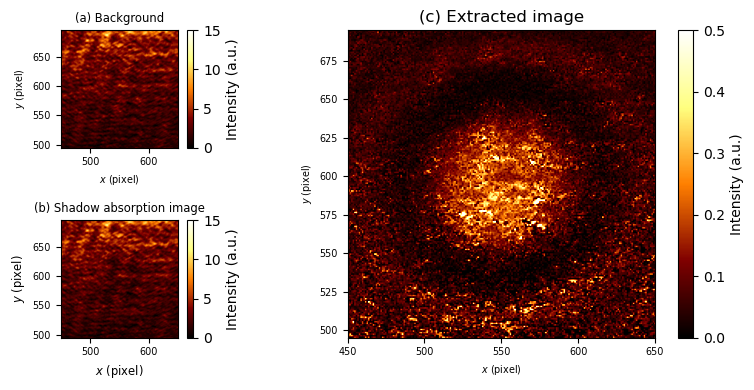

In [69]:
colormap_fig1 = 'afmhot'
fig = plt.figure(figsize=(8, 4))
axs = np.zeros(3, dtype=object)
gs = fig.add_gridspec(2, 3)
axs[0] = fig.add_subplot(gs[0, 0])
axs[1] = fig.add_subplot(gs[1, 0])
axs[2] = fig.add_subplot(gs[0:2,1:3])


axs1 = axs[0].imshow(sum_wo_a[495:695,450:650],vmin=0,vmax=15,extent =(450,650,495,695),cmap = colormap_fig1)
axs[0].set_title('(a) Background',fontsize = 'small')
axs[0].set_xlabel('$x$ (pixel)',fontsize = 'x-small')
axs[0].set_ylabel('$y$ (pixel)',fontsize = 'x-small')
fig.colorbar(axs1, ax=axs[0], label = 'Intensity (a.u.)')

axs2 = axs[1].imshow(sum_w_a[495:695,450:650],vmin=0,vmax=15,extent =(450,650,495,695),cmap = colormap_fig1)
axs[1].set_title('(b) Shadow absorption image',fontsize = 'small')
axs[1].set_xlabel('$x$ (pixel)',fontsize = 'small')
axs[1].set_ylabel('$y$ (pixel)',fontsize = 'small')
fig.colorbar(axs2, ax=axs[1], label = 'Intensity (a.u.)')
axs3 = axs[2].imshow(sum_sub[495:695,450:650],vmin=0,vmax=0.5,extent =(450,650,495,695),cmap = colormap_fig1)
axs[2].set_title('(c) Extracted image')
axs[2].set_xlabel('$x$ (pixel)',fontsize = 'x-small')
axs[2].set_ylabel('$y$ (pixel)',fontsize = 'x-small')
fig.colorbar(axs3, ax=axs[2], label = 'Intensity (a.u.)')
for x in axs.flat:
    for tick in x.xaxis.get_major_ticks():
        tick.label.set_fontsize('x-small')
    for tick in x.yaxis.get_major_ticks():
        tick.label.set_fontsize('x-small')
# fig.suptitle('Cropped extract image from background elimination')
fig.tight_layout()
plt.savefig('D:\\PICTURE\\Picture\\Pyplot\\2nd\\Cropped extract image.png')

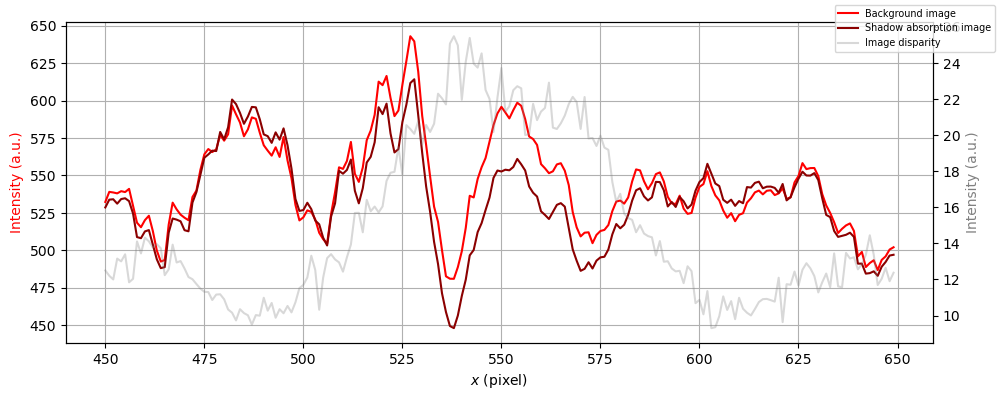

In [70]:
fig,ax = plt.subplots(figsize = (10,4))

ax.plot(np.arange(450,650),sum_l_wo,'-',color = 'red',label = 'Background image')
ax.plot(np.arange(450,650),sum_l_w,'-',color = 'darkred',label = 'Shadow absorption image')
ax.set_xlabel('$x$ (pixel)')
ax.set_ylabel('Intensity (a.u.)',color='red')
ax.grid()

ax2=ax.twinx()
ax2.plot(np.arange(450,650),sum_l_sub,'-',color='gray',alpha = 0.3 ,label = 'Image disparity')
ax2.set_ylabel('Intensity (a.u.)',color='gray')

# fig.suptitle('Image disparity between two images')


fig.tight_layout()
fig.legend(fontsize = 'x-small')
plt.savefig('D:\\PICTURE\\Picture\\Pyplot\\2nd\\Image disparity between two images.png')


<h1>Signal Analyze<h1>

In [17]:
single_subtract = []
MOT_pic_subtract = []

filelist = ['Mot_18-08\\1ms.tif','Mot_18-08\\2ms.tif','Mot_18-08\\3ms.tif','Mot_18-08\\4ms.tif',
            'Mot_18-08\\5ms.tif','Mot_18-08\\6ms.tif']#,'Mot_18-08\\7ms.tif','Mot_18-08\\8ms.tif',
            #'Mot_18-08\\9ms.tif','Mot_18-08\\10ms.tif'
n_of_point = 0
for imagefile in filelist:
    im = io.imread(imagefile).astype(np.int8)
    pic_per_time_point = int(im.shape[0] / 2)
    single_subtract = []
    
    for i in range(pic_per_time_point):
        
        with_out_mot = im[(2 * i) + 1]
        with_mot = im[(2 * i)]
        subtract_array = np.zeros(with_out_mot.shape)
        subtract_array[with_out_mot != 0] = 1 - (with_mot[with_out_mot != 0] / with_out_mot[with_out_mot != 0])
        subtract_array[subtract_array < 0] = 0
        
        single_subtract.append(subtract_array)
    MOT_pic_subtract.append(single_subtract)
    n_of_point += 1

In [18]:
yt,yb,xl,xr = 490,690,450,650
crop_width = yb-yt
sum_1d_data = []
average_pic_data = []
for i in range(6):
    sum_pic = 0
    
    for j in range(pic_per_time_point):
        sum_pic += MOT_pic_subtract[i][j][yt:yb,xl:xr]
        
    sum_1d_data.append(np.sum(sum_pic) / pic_per_time_point)    
    average_pic_data.append(sum_pic / pic_per_time_point)

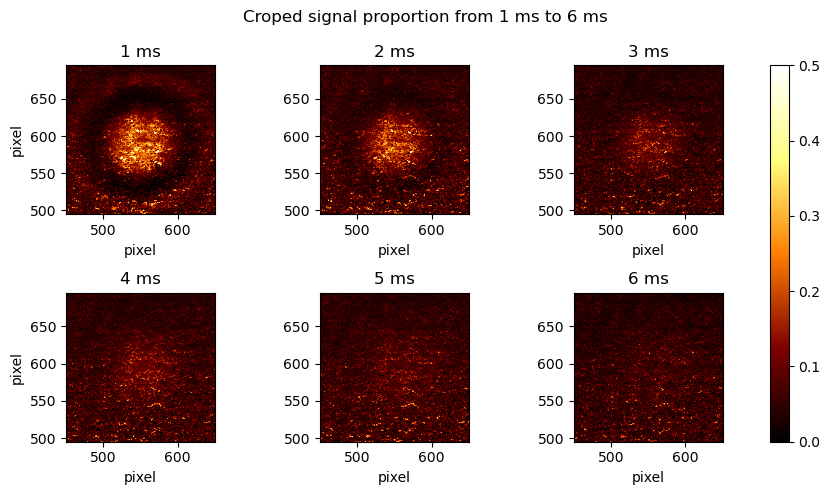

In [19]:
fig,(axs)=plt.subplots(2,3,figsize=(10,5))
k=1
for g in range(2):
    axs[g,0].set_ylabel('pixel')
    for p in range(3):
        pcm = axs[g,p].imshow(average_pic_data[k-1],vmin=0,vmax=0.5,cmap = 'afmhot',extent =(450,650,495,695))
        axs[g,p].set_title(str(k)+' ms')
        axs[g,p].set_xlabel('pixel')
        k+=1
fig.suptitle('Croped signal proportion from 1 ms to 6 ms')       
fig.tight_layout()     
fig.colorbar(pcm, ax=axs)

# plt.savefig('Cropped subtract signal.png')

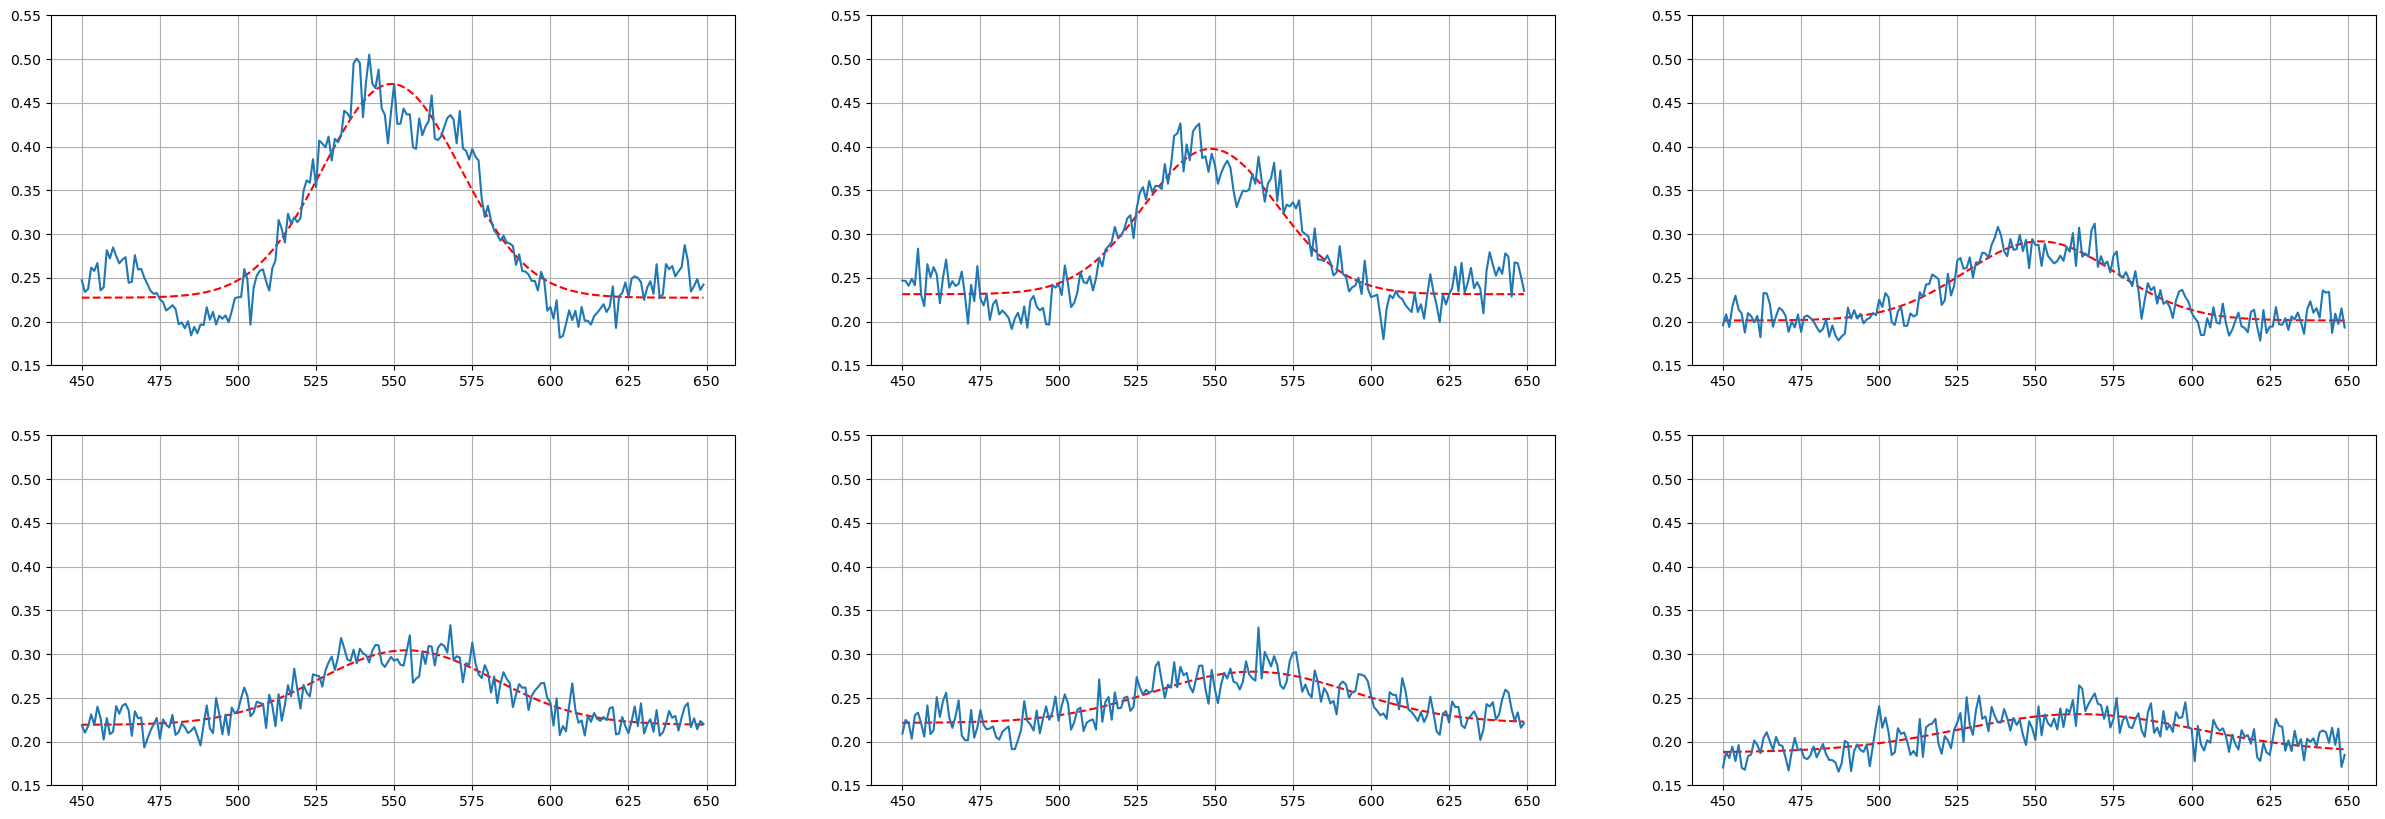

In [20]:
x_sum=np.zeros(crop_width)
x_sum_data=[]
for i in range(6):
    for j in range(crop_width):
        b=np.sum(average_pic_data[i][0:200,j])
        x_sum[j]=b/50
    x_sum_data.append(x_sum)
    x_sum=np.zeros(200)

fig,(axs)=plt.subplots(2,3,figsize=(30,10))

k=0
for g in range(2):
    for p in range(3):
        axs[g,p].plot(np.arange(450,650), gauss(np.arange(crop_width), *gauss_fit(np.arange(crop_width), x_sum_data[k])),'--',color='red')
        axs[g,p].plot(np.arange(450,650), x_sum_data[k])
        axs[g,p].grid()
        axs[g,p].set_ylim(0.15,0.55)
        k+=1

<h1>Ellipse fitting<h1>

[167.62892150878906, 162.45006561279297, 167.86226654052734, 112.28270149230957, 29.456253051757812, 172.24556732177734]


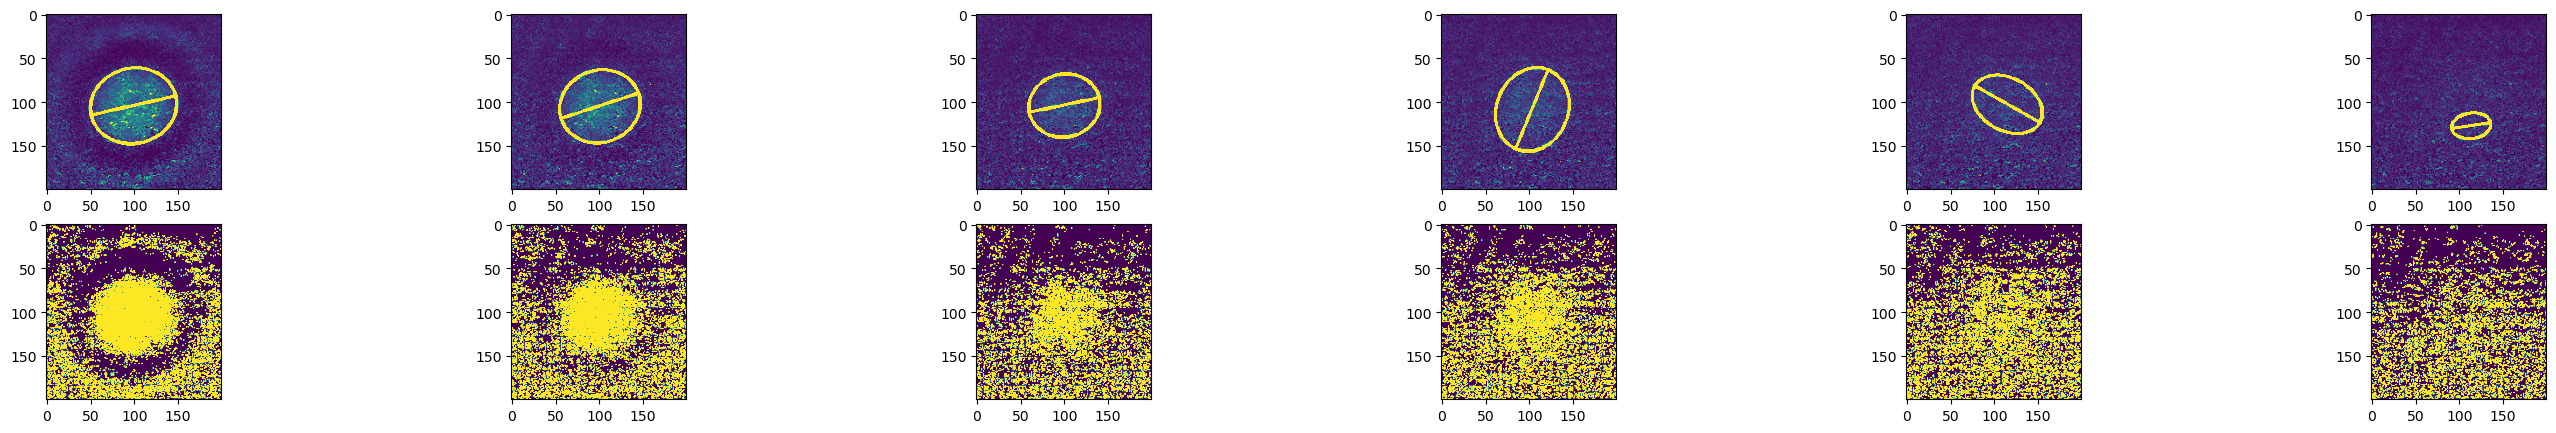

In [21]:
mul_sum_pic_data = np.round(np.array(average_pic_data)*100)
thresh_list = []
Elip_fit = []
angles = []

for i in range(6):
    Elipse_pic_mot, angle_mot , thresh_mot = eclipse_fit_full(mul_sum_pic_data[i])
    angles.append(angle_mot)
    Elip_fit.append(Elipse_pic_mot)
    thresh_list.append(thresh_mot)
    
fig,(axs)=plt.subplots(2,6,figsize=(35,5))
k=0

print(angles)
for p in range(6):
    axs[1,p].imshow(thresh_list[k],vmin=0,vmax=50)
    axs[0,p].imshow(Elip_fit[k],vmin=0,vmax=50)
    k+=1

In [22]:
Elipse_pic1, angle_1 , thresh_1 = eclipse_fit_full(mul_sum_pic_data[0])

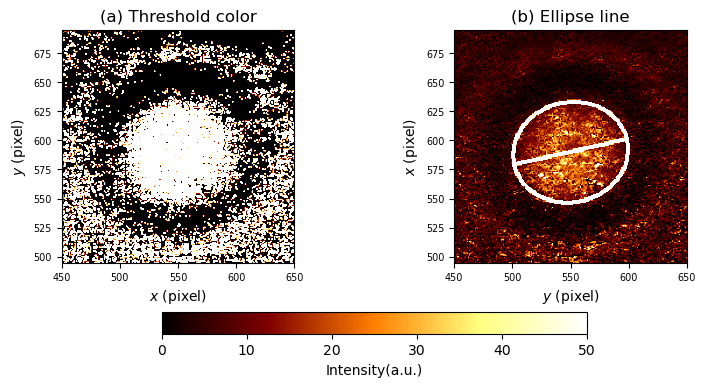

In [71]:
colormap_fig3 = 'afmhot'
fig = plt.figure(figsize=(8, 4))
axs = np.zeros(2, dtype=object)
gs = fig.add_gridspec(1,2)
axs[0] = fig.add_subplot(gs[0,0])
axs[1] = fig.add_subplot(gs[0,1])


axs1 = axs[0].imshow(thresh_1,cmap = colormap_fig3,vmin=0,vmax=50,extent =(450,650,495,695))
axs[0].set_title('(a) Threshold color')
axs[0].set_xlabel('$x$ (pixel)')
axs[0].set_ylabel('$y$ (pixel)')
# fig.colorbar(axs1, ax=axs[0], location='bottom')


axs2 = axs[1].imshow(Elipse_pic1,cmap = colormap_fig3,vmin=0,vmax=50,extent =(450,650,495,695))
axs[1].set_title('(b) Ellipse line')
axs[1].set_ylabel('$x$ (pixel)')
axs[1].set_xlabel('$y$ (pixel)')
# fig.colorbar(axs2, ax=axs[1], location='bottom')


for x in axs.flat:
    for tick in x.xaxis.get_major_ticks():
        tick.label.set_fontsize('x-small')
    for tick in x.yaxis.get_major_ticks():
        tick.label.set_fontsize('x-small')
# fig.suptitle('Ellipse fitting of the image')  
fig.tight_layout()    
fig.colorbar(axs1, ax=axs[:2], shrink=0.6, location='bottom', label = 'Intensity(a.u.)')
plt.savefig('D:\\PICTURE\\Picture\\Pyplot\\2nd\\Ellipse fitting.png')

<h1>Re analyze<h1>

In [25]:
MOT_subtract = []
data_range = 6
for i in range(data_range):
    single_MOT_subtract = []
    for j in range(pic_per_time_point):
        single_MOT_subtract.append(rotate((MOT_pic_subtract[i][j]),angle_1))
    MOT_subtract.append(single_MOT_subtract)

In [26]:
full_signal_rot = []
for i in range(6):
    signal_rot = np.zeros((1363, 1638))
    for j in range(15):
        signal_rot += MOT_subtract[i][j]
    full_signal_rot.append(signal_rot/15)

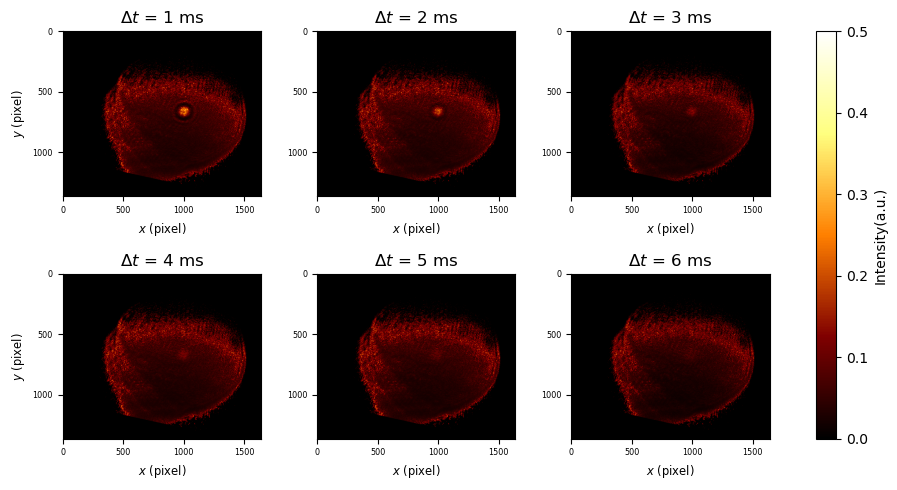

In [72]:
fig,(axs)=plt.subplots(2,3,figsize=(10,5))
k=1
for g in range(2):
    axs[g,0].set_ylabel('$y$ (pixel)',fontsize = 'small')
    for p in range(3):
        pcm = axs[g,p].imshow(full_signal_rot[k-1],vmin=0,vmax=0.5,cmap = 'afmhot')
        axs[g,p].set_title('$\Delta t$ = '+str(k)+' ms')
        axs[g,p].set_xlabel('$x$ (pixel)',fontsize = 'small')
        k+=1
for x in axs.flat:
    for tick in x.xaxis.get_major_ticks():
        tick.label.set_fontsize('xx-small')
    for tick in x.yaxis.get_major_ticks():
        tick.label.set_fontsize('xx-small')
# fig.suptitle('Image rotating with angle '+r'$167.628^o$')  
fig.tight_layout()     
fig.colorbar(pcm, ax=axs, label = 'Intensity(a.u.)')
plt.savefig('D:\\PICTURE\\Picture\\Pyplot\\2nd\\Image rotating.png')

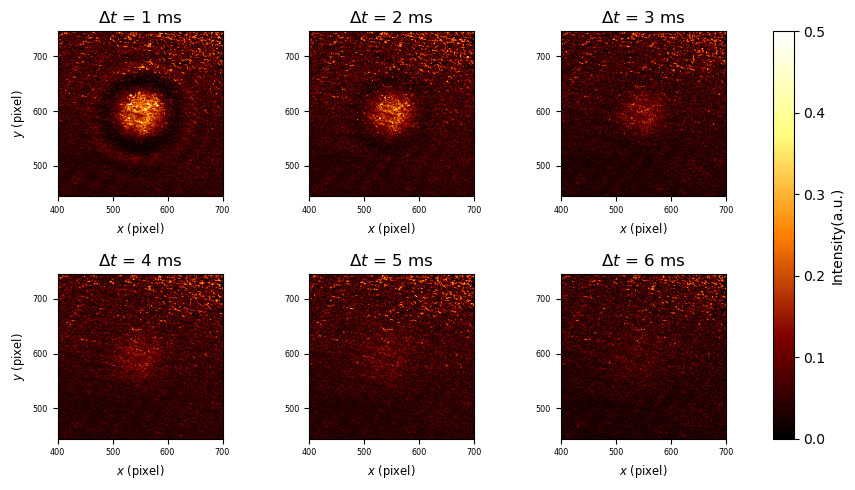

In [73]:
yt,yb,xl,xr=515,815,845,1145
new_crop_width = yb-yt
crop_signal_rot = [full_signal_rot[i][515:815,845:1145] for i in range(6)]

fig,(axs)=plt.subplots(2,3,figsize=(10,5))
# fig,(axs)=plt.subplots(1,6,figsize=(10,5))
k=1
for g in range(2):
    axs[g,0].set_ylabel('$y$ (pixel)',fontsize = 'small')
    for p in range(3):
        pcm = axs[g,p].imshow(crop_signal_rot[k-1],vmin=0,vmax=0.5,cmap = 'afmhot',extent =(400,700,445,745))
        axs[g,p].set_title('$\Delta t$ = '+str(k)+' ms')
        axs[g,p].set_xlabel('$x$ (pixel)',fontsize = 'small')
        k+=1
# for g in range(6):
#     pcm = axs[g].imshow(crop_signal_rot[k-1],vmin=0,vmax=0.5,cmap = 'afmhot',extent =(400,700,445,745))
#     axs[g].set_title(str(k)+' ms')
#     axs[g].set_xlabel('pixel',fontsize = 'small')
#     axs[0].set_ylabel('pixel',fontsize = 'small')
    # axs[g].spines['right'].set_visible(False)
    # axs[g].spines['left'].set_visible(False)
    # axs[g].yaxis.set_visible(False)
    # axs[g].xaxis.set_visible(False)
    # k+=1
for x in axs.flat:
    for tick in x.xaxis.get_major_ticks():
        tick.label.set_fontsize('xx-small')
    for tick in x.yaxis.get_major_ticks():
        tick.label.set_fontsize('xx-small')
# fig.suptitle('Croped of rotated image')  
fig.tight_layout()     
fig.colorbar(pcm, ax=axs,shrink=1, label = 'Intensity(a.u.)')
plt.savefig('D:\\PICTURE\\Picture\\Pyplot\\2nd\\Croped of rotated image.png')

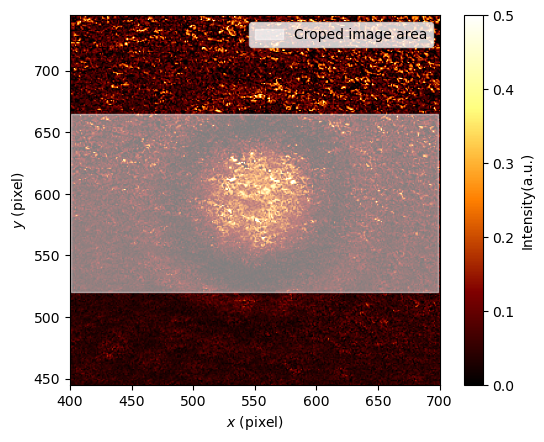

In [74]:
plt.imshow(crop_signal_rot[0],vmin=0,vmax=0.5,cmap = 'afmhot',extent =(400,700,445,745))
plt.fill_between(np.arange(401,700),520*np.ones(299),665*np.ones(299),color = 'white',alpha = 0.5,label = 'Croped image area')

plt.xlabel('$x$ (pixel)')
plt.ylabel('$y$ (pixel)')
plt.legend()
# plt.title('Selection area of summation along 1-axis')
plt.colorbar(shrink=1, label = 'Intensity(a.u.)')
plt.savefig('D:\\PICTURE\\Picture\\Pyplot\\2nd\\Selection area of summation.png')

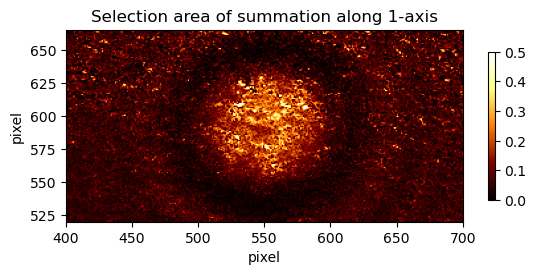

In [25]:
plt.imshow(crop_signal_rot[0][75:225,:],vmin=0,vmax=0.5,cmap = 'afmhot',extent =(400,700,520,665))
plt.xlabel('pixel')
plt.ylabel('pixel')
plt.title('Selection area of summation along 1-axis')
plt.colorbar(shrink=0.4)
# plt.savefig('Selection area of summation signal.png')

In [32]:
gauss_data = np.zeros([6,300])
gauss_fit_data = np.zeros([6,300])
sigma_exp = []
sigma_err = []
for j in range(6):
    for i in range(300):
        gauss_data[j,i] = np.sum(crop_signal_rot[j][75:225,i])
    gauss_fit_data[j] = gauss(np.arange(300), *gauss_fit(np.arange(300), gauss_data[j]))
    sigma_exp.append(np.abs(gauss_fit(np.arange(300), gauss_data[j])[3]))
    pcov_sigma = np.abs(gauss_fit_pcov(np.arange(300), gauss_data[j]))
    sigma_err.append(np.sqrt(np.diag(pcov_sigma))[3])

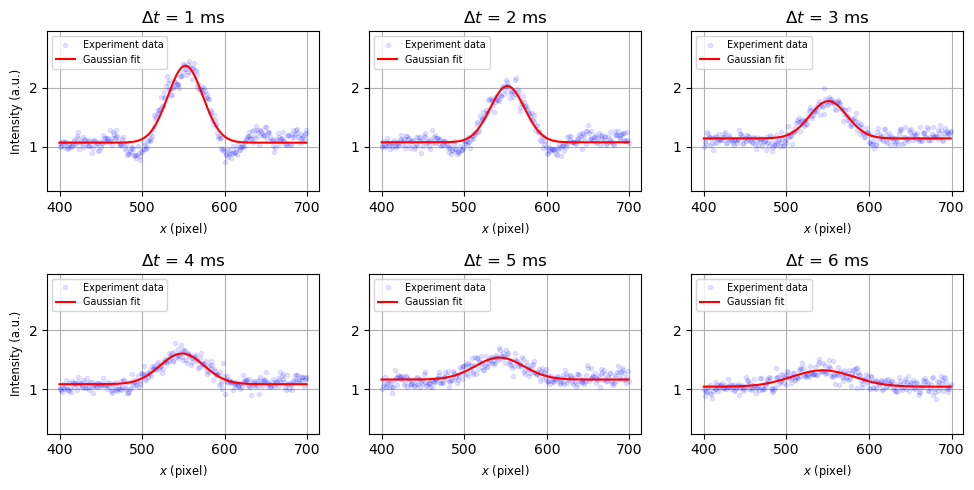

In [75]:
fig,(axs)=plt.subplots(2,3,figsize=(10,5))
k=1
for g in range(2):
    axs[g,0].set_ylabel('Intensity (a.u.)',fontsize= 'small')
    for p in range(3):
        norm_gauss_data = gauss_data[k-1]/gauss_data[k-1][0]
        norm_gauss_data_fit = gauss_fit_data[k-1]/gauss_data[k-1][0]
        axs[g,p].plot(np.arange(400,700),norm_gauss_data,'.',alpha = 0.1,color = 'blue',label = 'Experiment data')
        axs[g,p].plot(np.arange(400,700),norm_gauss_data_fit,'-r',label = 'Gaussian fit')
        axs[g,p].set_title('$\Delta t$ = '+str(k)+' ms')
        axs[g,p].grid()
        axs[g,p].legend(loc = 'upper left',fontsize= 'x-small')
        axs[g,p].set_ylim(np.min(gauss_data[0]/gauss_data[0][0])-0.5,np.max(gauss_data[0]/gauss_data[0][0])+0.5)
        axs[g,p].set_xlabel('$x$ (pixel)',fontsize= 'small')
        k+=1
# fig.suptitle('Atomic cloud in one dimention (1D)')  
fig.tight_layout()
plt.savefig('D:\\PICTURE\\Picture\\Pyplot\\2nd\\Sum of image along x-axis.png')

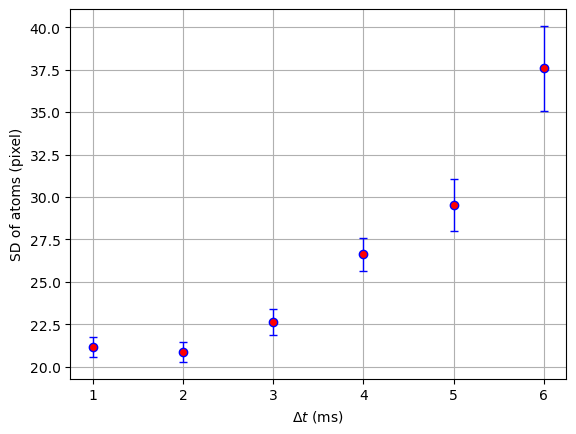

In [76]:
time = np.arange(1,7,1)
plt.figure()
# plt.title('Ballistic expansion of Rubidium atomic cloud')
plt.grid()
plt.errorbar(time ,np.array(sigma_exp), np.array(sigma_err),color = 'blue',fmt ='o',label = 'raw data',capsize=3, elinewidth=1, mfc = 'red')
plt.ylabel('SD of atoms (pixel)')
plt.xlabel('$\Delta t$ (ms)')
plt.savefig('D:\\PICTURE\\Picture\\Pyplot\\2nd\\Ballistic expansion.png')